<a href="https://colab.research.google.com/github/gmazzitelli/GSN2/blob/master/rateVsSizeAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import seaborn as sns
sns.set()
def panda_from_gspreadsheet(key, sheet_name='Sheet1', header=0):
  # google spredsheet TO panda dataframe 
  # ricordarsi di abilitare lo sharing pubblico dei dati
  url = 'https://docs.google.com/spreadsheets/d/{key}/gviz/tq?tqx=out:csv&sheet={sheet_name}&headers=1'.format(
      key=key, sheet_name=sheet_name.replace(' ', '%20'))
  return pd.read_csv(url, header=header)

#https://docs.google.com/spreadsheets/d/1MWRb1xbkpZOmUBLCLaC9ud4htvPEWYC7F8IuTt84YBg/
pd =  panda_from_gspreadsheet('1MWRb1xbkpZOmUBLCLaC9ud4htvPEWYC7F8IuTt84YBg', sheet_name='Sheet1')

def Exp(x, p0, p1): # negative exponential
  import numpy as np
  return p0*np.exp(x/p1)

def Line(x, m, q):
  import numpy as np
  return m*x + q
  
def Gain(x, p0, p1):
  import numpy as np
  return p0*x**p1

In [2]:
pd.tail()

,Timestamp,Email Address,Experiment,DAQ type,Data organization,DAQ rate events/y,Data amount,size KB,Data size,Data structure,...,Storage - POSIX,Storage - access,Tape - size,Tape - access frequency,Tape - inventory,Tape - replicas and backups,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44
27,5/3/2022 11:48:25,federico.dipierro@to.infn.it,CTA,triggered,by event,1.040000e+09,Current (2022) data production: 1 telescope ta...,8000.0,100 kB,"RAW, DL0, DL1, DL2, DL3, MC",...,1,Grid certificate,500 TB,A = 0,B = 1,No,NaN,NaN,NaN,NaN
28,5/3/2022 15:00:28,aldo.ianni@lngs.infn.it,SABRE,simulated,by event,6.200000e+03,MC generated 1e10. Real events in the ROI 6200...,1700000.0,Order of 0.7 GByte for physics run. Order of 1...,raw(real + MC) + calibrated + filtered (after ...,...,,Collaborators with LNGS account,At least 120 TB,,,Yes. Yes for a good fraction at present.,NaN,NaN,NaN,NaN
29,5/5/2022 16:28:43,matteo.merge@roma2.infn.it,CSES-LIMADOU,triggered,by event,1.000000e+09,~1.0x10^9 events/year,2.0,~2kB/event (~ 2.0TB/year),"raw, level0 (root format of raw data), level1 ...",...,100%,"INFN Personnel and INFN associated hosts, PHd ...",8TB is the current pledge @CNAF for HEPD-01 ra...,No frequent tape accesses are forseen,"All the stored data on tape at CNAF are a ""mas...",There are replicas of tape data ASI-SSDC and I...,NaN,NaN,NaN,NaN
30,5/5/2022 18:04:09,bagnasco@to.infn.it,Virgo,streaming,"h(t) (""strain"") time series sampled at 10kHz, ...",3.150000e+04,About 2PB of raw data per year of observation....,62000000.0,The basic units for offline processing are fil...,Full bandwidth raw (not saved); Bulk raw (down...,...,"Can be negotiated. Posix access is preferred, ...",See answer in previous section. We are gradual...,~4PB,~0%,~100%,CNAF storage is considered custodial for Virgo...,NaN,NaN,NaN,NaN
31,5/10/2022 15:47:52,andrea.chiavassa@to.infn.it,SWGO,simulated,"L'esperimento è in fase di progettazione, al m...",1.000000e+07,Per i dati non sono in grado di rispondere ora...,300000.0,"Eventi simulati: 17MB (fotoni), 300 MB (protoni)",Non ancora stabilito,...,Lo storage POSIX sarebbe altamente preferibile,Tutta la collaborazione,"Al momento non è necessario uno storage su tape,","Al momento non è necessario uno storage su tape,","Al momento non è necessario uno storage su tape,","Al momento non è necessario uno storage su tape,",NaN,NaN,NaN,NaN


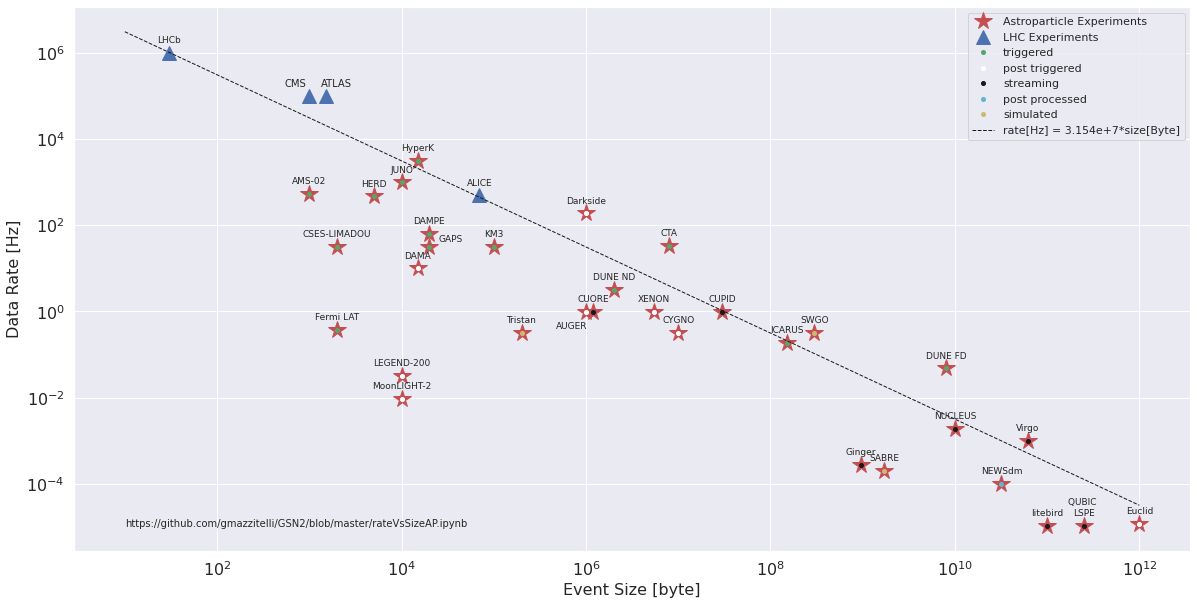

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
lhc_experiment = np.array(["ATLAS", "CMS", "LHCb", "ALICE"])
lhc_size = np.array([1.5e3,1e3,30,70e3])
lhc_rate = np.array([1e5,1e5,1e6,500])
x = np.array(pd["size KB"]*1e3)
y = np.array(pd["DAQ rate events/y"]/3.154e+7)
z = np.array(pd["DAQ type"])

ax.plot(x, y , 'r*', markersize=18, label="Astroparticle Experiments")
ax.plot(lhc_size, lhc_rate , 'b^', markersize=14, label="LHC Experiments")
ax.plot(x[z=="triggered"], y[z=="triggered"] , 'go', markersize=4, label="triggered")
ax.plot(x[z=="post triggered"], y[z=="post triggered"] , 'wo', markersize=4, label="post triggered")
ax.plot(x[z=="streaming"], y[z=="streaming"] , 'ko', markersize=4, label="streaming")

ax.plot(x[z=="post processed"], y[z=="post processed"] , 'co', markersize=4, label="post processed")
ax.plot(x[z=="simulated"], y[z=="simulated"] , 'yo', markersize=4, label="simulated")



# for i in range(len(x)):
#     ax.scatter(x[i], y[i] , marker='*', color=z[i], s=200)



size_day = np.logspace(1, 12, 10)
rate_day = Gain(size_day, 3.154e+7, -1)
ax.plot(size_day, rate_day , 'k--', label="rate[Hz] = 3.154e+7*size[Byte]", linewidth=1)


# popt, pcov = curve_fit(Gain,x, y, p0=[1e7, -1])
# perr = np.sqrt(np.diag(pcov))
# r2=r2_score(y, Gain(x, *popt))
# xf = np.linspace(10, 1e12, 100)
# ax.plot(xf, Gain(xf, *popt), 'k--', label='a = {0:.2e}±{1:.2e}\nb = {2:.2e}±{3:.2e} \
# \nr^2 = {4:.3f}'.format(popt[0], perr[0], popt[1], perr[1], r2))


for i, lab in enumerate(pd["Experiment"]):
    d = 0.7 # 1.2 if i%2 == 0 else 1.1
    if lab == "AUGER":
      plt.annotate(lab, (x[i]-(x[i]*0.3),y[i]-(y[i]*0.6)), ha='center', size=9) 
    elif lab == "GAPS":
      plt.annotate(lab, (x[i]+(x[i]*d),y[i]+(y[i]*0.3)), ha='center', size=9) 
    else:
      plt.annotate(lab, (x[i],y[i]+(y[i]*d)), ha='center', size=9) 


plt.annotate(lhc_experiment[0], (lhc_size[0]+lhc_size[0]*0.3,lhc_rate[0]+(lhc_rate[0]*0.7)), ha='center', size=10) 
plt.annotate(lhc_experiment[1], (lhc_size[1]-lhc_size[1]*0.3,lhc_rate[1]+(lhc_rate[1]*0.7)), ha='center', size=10) 
plt.annotate(lhc_experiment[2], (lhc_size[2],lhc_rate[2]+(lhc_rate[2]*0.7)), ha='center', size=9) 
plt.annotate(lhc_experiment[3], (lhc_size[3],lhc_rate[3]+(lhc_rate[3]*0.7)), ha='center', size=9) 

# for i, lab in enumerate(lhc_experiment):
#     d = -0.3 if i%2 == 0 else 0.3
#     plt.annotate(lab, (lhc_size[i]+lhc_size[i]*d,lhc_rate[i]-(lhc_rate[i]*0.7)), ha='center', size=9) 

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("Event Size [byte]", size = 16)
ax.set_ylabel("Data Rate [Hz]", size = 16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend()
plt.text(1e1, 1e-5, "https://github.com/gmazzitelli/GSN2/blob/master/rateVsSizeAP.ipynb")
plt.show()

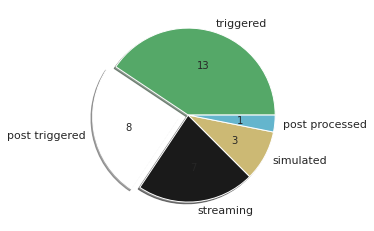

In [ ]:
colors = ["g", "w", "k", "y", "c"]
explode = [0, 0.1, 0, 0, 0]
elements = len(pd["DAQ type"])
pd.value_counts(pd["DAQ type"]).plot(kind='pie', autopct=lambda x: '{:.0f}'.format(x*elements/100), label="", 
                                     colors=colors, shadow=True, explode=explode)
plt.show()

In [ ]:
sa = 3.154e+7
b = sa/1000
b = 2e15/3.2e+04/1e3
"{:.1e}".format(b)


'6.2e+07'

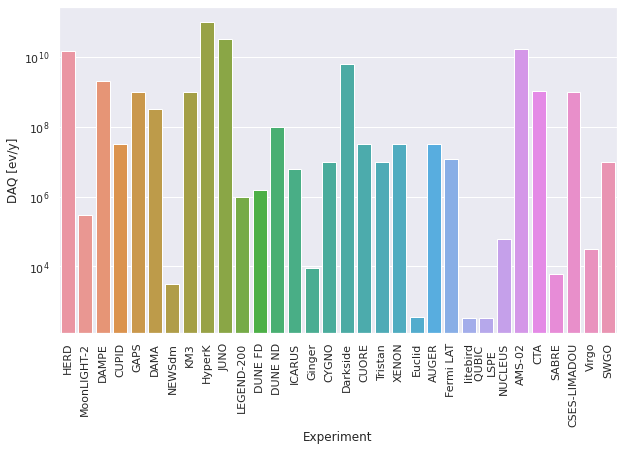

In [18]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=pd, x="Experiment", y="DAQ rate events/y")
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.set_ylabel("DAQ [ev/y]")
plt.show()

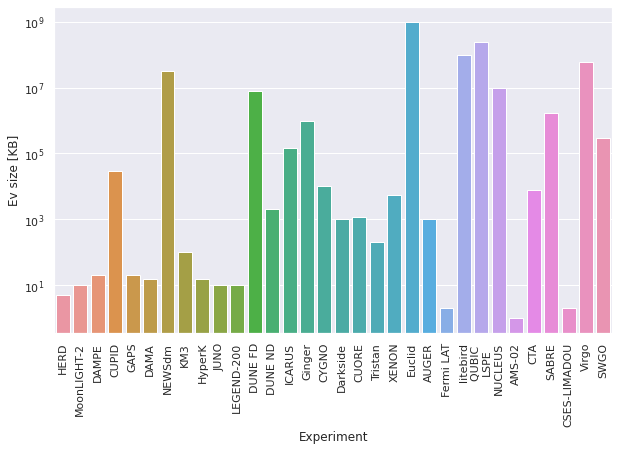

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=pd, x="Experiment", y="size KB")
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.set_ylabel("Ev size [KB]")
plt.show()

In [23]:
pd.columns

Index(['Timestamp', 'Email Address', 'Experiment', 'DAQ type',
       'Data organization', 'DAQ rate events/y', 'Data amount', 'size KB',
       'Data size', 'Data structure', 'Metadata/calibrations/slow-control',
       'Production sites', 'Workflow', 'Data access', 'Details',
       'Details, "arrows"', 'Details, "boxes"', 'CPU - total amount',
       'CPU - HPC', 'CPU - HTC', 'CPU - interactive', 'CPU - batch system',
       'CPU - web based tools', 'CPU - personal VMs', 'CPU - graphic access',
       'CPU - services', 'CPU - temporary overpledge',
       'CPU - special environment', 'CPU - R&D', 'Storage - size',
       'Storage - experiment data', 'Storage - user data',
       'Storage - secondary data', 'Storage - executables and libraries',
       'Storage - read-only', 'Storage - POSIX', 'Storage - access',
       'Tape - size', 'Tape - access frequency', 'Tape - inventory',
       'Tape - replicas and backups', 'Unnamed: 41', 'Unnamed: 42',
       'Unnamed: 43', 'Unnamed: 44']

In [28]:
pd.values

array([['4/19/2022 19:30:31', 'mori@fi.infn.it', 'HERD', ..., nan, nan,
        nan],
       ['4/20/2022 14:44:47', 'luca.porcelli@lnf.infn.it', 'MoonLIGHT-2',
        ..., nan, nan, nan],
       ['4/22/2022 15:15:19', 'margherita.disanto@gssi.it', 'DAMPE', ...,
        nan, nan, nan],
       ...,
       ['5/5/2022 16:28:43', 'matteo.merge@roma2.infn.it',
        'CSES-LIMADOU', ..., nan, nan, nan],
       ['5/5/2022 18:04:09', 'bagnasco@to.infn.it', 'Virgo', ..., nan,
        nan, nan],
       ['5/10/2022 15:47:52', 'andrea.chiavassa@to.infn.it', 'SWGO', ...,
        nan, nan, nan]], dtype=object)